In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def gaussianpeak_testing():
    """ Test the Gaussian peak or dip estimator. """

    x_axis = np.linspace(0, 5, 50)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 4000*abs(np.random.normal(size=x_axis.shape))

    stepsize = abs(x_axis[1] - x_axis[0])
    n_steps = len(x_axis)


    # Smooth the provided data, so that noise fluctuations will
    # not disturb the parameter estimation.
    std_dev = 2
    data_smoothed = filters.gaussian_filter1d(data_noisy, std_dev)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='data')
    plt.plot(x_axis, data_smoothed, label='smoothed data')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    # Define constraints
    # maximal and minimal the length of the given array to the right and to the
    # left:
    center_min = (x_axis[0]) - n_steps * stepsize
    center_max = (x_axis[-1]) + n_steps * stepsize
    ampl_min = 0
    sigma_min = stepsize
    sigma_max = 3 * (x_axis[-1] - x_axis[0])

    # set parameters
    offset = data_smoothed.min()
    params['offset'].set(value=offset)

    # it is more reliable to obtain select the maximal value rather then
    # calculating the first moment of the gaussian distribution (which is the
    # mean value), since it is unreliable if the distribution begins or ends at
    # the edges of the data:
    mean_val_calc =  np.sum(x_axis*(data_smoothed)) / np.sum(data_smoothed)
    center_val = x_axis[np.argmax(data_smoothed)]
    params['center'].set(value=center_val, min=center_min, max=center_max)

    # calculate the second moment of the gaussian distribution: int (x^2 * f(x) dx)
    mom2 = np.sum((x_axis)**2 * (data_smoothed)) / np.sum(data_smoothed)

    # and use the standard formula to obtain the standard deviation:
    #   sigma^2 = int( (x-mean)^2 f(x) dx ) = int (x^2 * f(x) dx) - mean^2

    print("mom2", mom2)
    print("std: ", np.sqrt(abs(mom2 - mean_val_calc**2)))

    # if the mean is situated at the edges of the distribution then this
    # procedure performs better then setting the initial value for sigma to
    # 1/3 of the length of the distibution since the calculated value for the
    # mean is then higher, which will decrease eventually the initial value for
    # sigma. But if the peak values is within the distribution the standard
    # deviation formula performs even better:
    params['sigma'].set(value=np.sqrt(abs(mom2 - mean_val_calc**2)), min=sigma_min, max=sigma_max)

    # do not set the maximal amplitude value based on the distribution, since
    # the fit will fail if the peak is at the edges or beyond the range of the
    # x values.
    params['amplitude'].set(value=data_smoothed.max() - data_smoothed.min(), min=ampl_min)

    result = mod_final.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis,result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis,result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

mom2 8.73318132385
std:  1.36809545982
[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 50
    # variables        = 4
    chi-square         = 186347901.067
    reduced chi-square = 4051041.328
[[Variables]]
    fwhm:        2.43132422 +/- 0.308071 (12.67%)  == '2.3548200450309493*sigma'
    contrast:    77.5194986 +/- 11.96268 (15.43%)  == '(amplitude/offset)*100'
    amplitude:   10142.3186 +/- 946.6548 (9.33%) (init= 10616.12)
    center:      3.02767602 +/- 0.069834 (2.31%) (init= 3.367347)
    sigma:       1.03248833 +/- 0.130825 (12.67%) (init= 1.368095)
    offset:      13083.5710 +/- 914.7807 (6.99%) (init= 12971.12)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, offset)             = -0.832 
    C(amplitude, offset)         = -0.783 
    C(amplitude, sigma)          =  0.447 
    C(center, offset)            =  0.103 



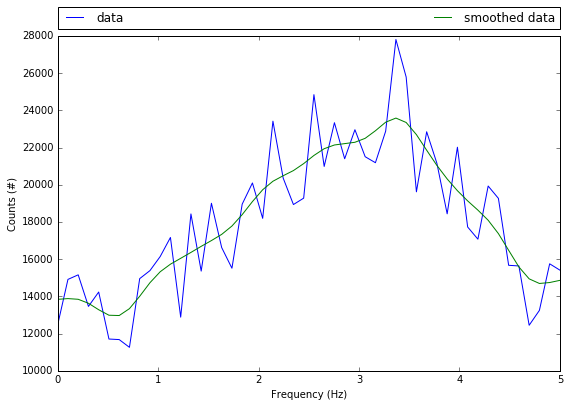

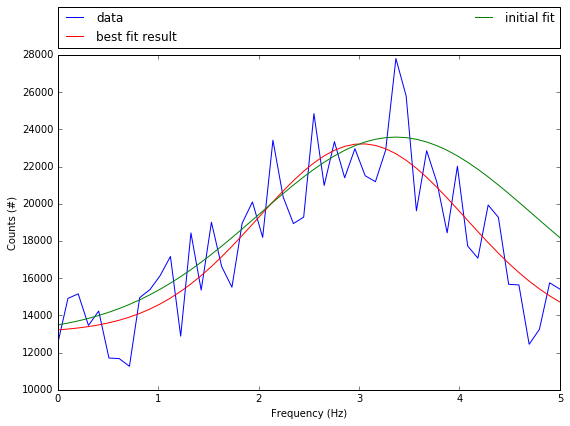

In [3]:
gaussianpeak_testing()

In [4]:
def gaussianpeak_testing2():
    """ Test the implemented Gaussian peak fit. """

    x_axis = np.linspace(0, 5, 11)

    ampl = 10000
    center = 3
    sigma = 1
    offset = 10000

    mod_final, params = fitlogic.make_gaussian_model()
    data_noisy = mod_final.eval(
        x=x_axis,
        amplitude=ampl,
        center=center,
        sigma=sigma,
        offset=offset) + 2000*abs(np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussian_fit(x_axis=x_axis, data=data_noisy, estimator=fitlogic.estimate_gaussian_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy,'-b', label='data')
    plt.plot(x_axis, result.best_fit,'-r', label='best fit result')
    plt.plot(x_axis, result.init_fit,'-g',label='initial fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()
    print(result.fit_report())

[[Model]]
    ((Model(amplitude_function) * Model(physical_gauss)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 49
    # data points      = 11
    # variables        = 4
    chi-square         = 8105567.644
    reduced chi-square = 1157938.235
[[Variables]]
    fwhm:        2.57659416 +/- 0.351594 (13.65%)  == '2.3548200450309493*sigma'
    contrast:    92.0719169 +/- 16.19962 (17.59%)  == '(amplitude/offset)*100'
    amplitude:   10301.8805 +/- 1.04e+03 (10.07%) (init= 6650.732)
    center:      3.13799957 +/- 0.083803 (2.67%) (init= 3)
    sigma:       1.09417879 +/- 0.149308 (13.65%) (init= 1.51464)
    offset:      11188.9497 +/- 972.6780 (8.69%) (init= 12156.93)
[[Correlations]] (unreported correlations are <  0.100)
    C(sigma, offset)             = -0.812 
    C(amplitude, offset)         = -0.757 
    C(amplitude, sigma)          =  0.389 
    C(center, offset)            =  0.104 



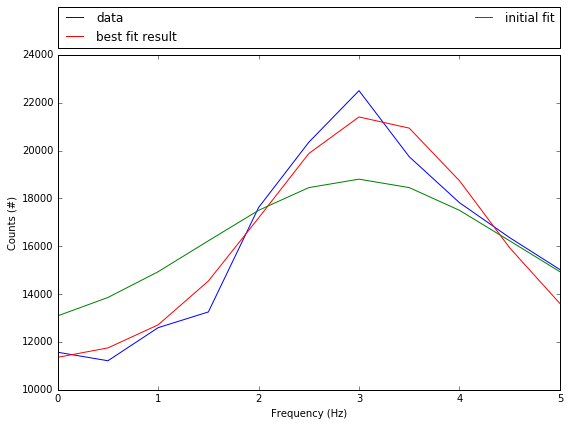

In [5]:
gaussianpeak_testing2()

In [9]:
def two_gaussian_peak_testing():
    """ Test the implemented estimator for two gaussian peaks with offset """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000+np.random.random(1)*50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000+np.random.random(1)*20000
    sigma1 = 25000+np.random.random(1)*20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0


    data_noisy=(mod.eval(x=x_axis,params=params) + 20000*np.random.normal(size=x_axis.shape))

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    threshold_fraction=0.4
    minimal_threshold=0.2
    sigma_threshold_fraction=0.3

    mod_lor, params_lor = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    error, params_lor = fitlogic.estimate_lorentziandouble_dip(
        x_axis=x_axis,
        data=-data_noisy,
        params=params_lor,
        threshold_fraction=threshold_fraction,
        minimal_threshold=minimal_threshold,
        sigma_threshold_fraction=sigma_threshold_fraction)

    result_lor = mod_lor.fit(-data_noisy, x=x_axis, params=params_lor)

    plt.figure()
    plt.plot(x_axis, -data_noisy, label="data")
    plt.plot(x_axis, result_lor.init_fit, label='init lorentz fit')
    plt.plot(x_axis, result_lor.best_fit, label='actual lorentz fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    params['g0_amplitude'].value = -params_lor['l0_amplitude'].value
    params['g0_center'].value = params_lor['l0_center'].value
    params['g0_sigma'].value = params_lor['l0_sigma'].value/(np.sqrt(2*np.log(2)))
    params['g1_amplitude'].value = -params_lor['l1_amplitude'].value
    params['g1_center'].value = params_lor['l1_center'].value
    params['g1_sigma'].value = params_lor['l1_sigma'].value/(np.sqrt(2*np.log(2)))
    params['offset'].value = -params_lor['offset'].value

    result = mod.fit(data_noisy, x=x_axis, params=params)
    print(result.fit_report())
    
    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

[[Model]]
    (((Model(amplitude_function, prefix='g0_') * Model(physical_gauss, prefix='g0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='g1_') * Model(physical_gauss, prefix='g1_')))
[[Fit Statistics]]
    # function evals   = 174
    # data points      = 200
    # variables        = 7
    chi-square         = 74563393016.621
    reduced chi-square = 386338823.920
[[Variables]]
    g0_fwhm:        2.3933e+05 +/- 2.10e+05 (87.92%)  == '2.3548200450309493*g0_sigma'
    g0_contrast:   -260.734508 +/- 488.5581 (187.38%)  == '(g0_amplitude/offset)*100'
    g1_fwhm:        92879.0482 +/- 5.81e+03 (6.25%)  == '2.3548200450309493*g1_sigma'
    g1_contrast:   -5377.95458 +/- 5.25e+03 (97.70%)  == '(g1_amplitude/offset)*100'
    g0_amplitude:   12707.5654 +/- 1.82e+04 (143.31%) (init= 282630.4)
    g0_center:      2.0057e+05 +/- 1.41e+05 (70.36%) (init= 170351.8)
    g0_sigma:       1.0163e+05 +/- 8.94e+04 (87.92%) (init= 25237.9)
    offset:        -4873.75666 +/- 4.88e+

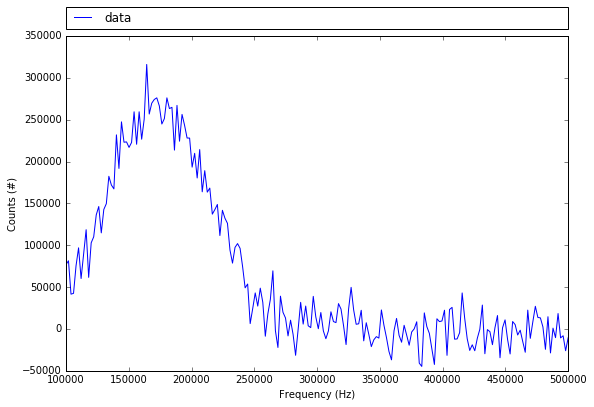

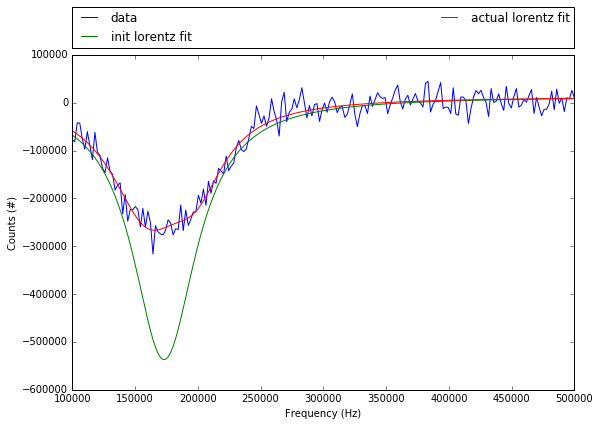

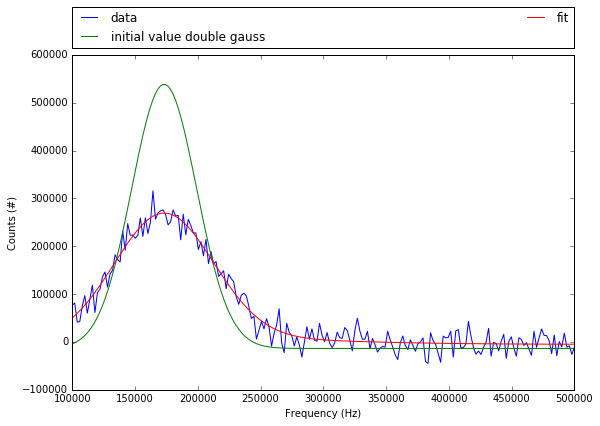

In [10]:
two_gaussian_peak_testing()

In [11]:
def two_gaussian_peak_testing2():
    """ Test the implemented Two Gaussian peak with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = 75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1)*200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 25000 + np.random.random(1) * 20000
    sigma1 = 25000 + np.random.random(1) * 20000
    splitting = 100000  # abs(np.random.random(1)*300000)

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = 0

    data_noisy = (mod.eval(x=x_axis,params=params) + 20000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_peak)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())

In [12]:
two_gaussian_peak_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-18547487ed06>", line 1, in <module>
    two_gaussian_peak_testing2()
  File "<ipython-input-11-3f7226333c1a>", line 35, in two_gaussian_peak_testing2
    estimator=fitlogic.estimate_gaussiandouble_peak)
  File "/home/jan/qo/qudi/logic/fitmethods/gaussianlikemethods.py", line 580, in make_gaussiandouble_fit
    'unit': units[0]}
TypeError: 'NoneType' object is not subscriptable


In [13]:
def two_gaussian_dip_testing2():
    """ Test the implemented Two Gaussian dip with offset fit. """

    start=100000
    stop= 500000
    num_points=int((stop-start)/2000)
    x_axis = np.linspace(start, stop, num_points)

    mod, params = fitlogic.make_multiplegaussianoffset_model(no_of_functions=2)

    amplitude0 = -75000 + np.random.random(1) * 50000
    amplitude1 = amplitude0*1.5
#    splitting = 100000  # abs(np.random.random(1)*100000)
    splitting = abs(np.random.random(1) * 200000)
    center0 = 160000
#    center1 = 300000
    center1 = center0 + splitting
    sigma0 = 2500 + np.random.random(1) * 8000
    sigma1 = 2500 + np.random.random(1) * 8000
    splitting = 100000  # abs(np.random.random(1)*300000)
    offset = 200000

    params['g0_amplitude'].value = amplitude0
    params['g0_center'].value = center0
    params['g0_sigma'].value = sigma0
    params['g1_amplitude'].value = amplitude1
    params['g1_center'].value = center1
    params['g1_sigma'].value = sigma1
    params['offset'].value = offset


    data_noisy=(mod.eval(x=x_axis,params=params) + 30000 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_gaussiandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_gaussiandouble_dip)

    plt.figure()
    plt.plot(x_axis, data_noisy, label="data")
    plt.plot(x_axis, result.init_fit, label='initial value double gauss')
    plt.plot(x_axis, result.best_fit, label='fit')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Counts (#)')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
    plt.show()

    print(result.fit_report())

In [14]:
two_gaussian_dip_testing2()

Traceback (most recent call last):
  File "/home/jan/qo/qudi/logic/jupyterkernel/qzmqkernel.py", line 795, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-b8b03bfe71aa>", line 1, in <module>
    two_gaussian_dip_testing2()
  File "<ipython-input-13-f224307f1a3c>", line 37, in two_gaussian_dip_testing2
    estimator=fitlogic.estimate_gaussiandouble_dip)
  File "/home/jan/qo/qudi/logic/fitmethods/gaussianlikemethods.py", line 580, in make_gaussiandouble_fit
    'unit': units[0]}
TypeError: 'NoneType' object is not subscriptable
